## <font color="blue">All Liabrary


In [18]:

import os
import joblib
import librosa
import warnings
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
from sklearn.model_selection import GridSearchCV
from statistics import mode
import seaborn as sns 
from scipy.io import wavfile as wav
from imblearn.over_sampling import SMOTE
from IPython.display import Image
from sklearn import tree
from sklearn.tree import export_graphviz
import graphviz
from sklearn.datasets import make_classification
from itertools import combinations
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB as gnb
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score,  recall_score
%matplotlib inline

## <font color="blue">EDA



In [19]:
healthy_dir = "/Users/yashtembhurnikar/Programming/Pccoe Final Year/Parkinson's Detection/AudioDataset/HC_AH"
parkinsons_dir = "/Users/yashtembhurnikar/Programming/Pccoe Final Year/Parkinson's Detection/AudioDataset/PD_AH"

In [20]:
def plot_waveform(audio_file, title):
    data, sample_rate = librosa.load(audio_file)
    plt.figure(figsize=(14, 5))
    plt.plot(data)
    plt.title(title + " Waveform")
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.show()

### Audio Visualization

In [21]:
# healthy_files = os.listdir(healthy_dir)
# for file in healthy_files:
#     audio_file = os.path.join(healthy_dir, file)
#     plot_waveform(audio_file, "Healthy")
   
    

In [22]:
# parkinsons_files = os.listdir(parkinsons_dir)
# for file in parkinsons_files:
#     audio_file = os.path.join(parkinsons_dir, file)
#     plot_waveform(audio_file, "Parkinson's")


## <font color="blue">Preprocessing 

### Feature Extraction From Audio Files

In [23]:
def extract_features(file_path,target_sr=22050,n_fft=512):
    audio, sr = librosa.load(file_path, sr=target_sr)  

    features = []
    fo = np.min(audio)
    fhi = np.max(audio)
    flo = np.min(np.abs(np.fft.fft(audio)))
    features.extend([fo, fhi, flo])
    
    jitter = librosa.effects.harmonic(audio)
    jitter_perc = np.mean(librosa.feature.rms(y=jitter))
    jitter_abs = np.mean(librosa.feature.rms(y=jitter, frame_length=1, hop_length=1))
    rap = np.mean(librosa.onset.onset_strength(y=audio, sr=sr, hop_length=512))
    ddp = rap * 2
    ppq = np.mean(librosa.feature.tempogram(y=audio, sr=sr))
    features.extend([jitter_perc, jitter_abs, rap, ppq, ddp])
    
    shimmer = np.mean(np.abs(np.diff(audio))) / np.mean(np.abs(audio))
    shimmer_db = 10 * np.log10(shimmer)
    apq3 = np.mean(librosa.feature.spectral_bandwidth(S=np.abs(librosa.stft(audio)), sr=sr, p=3))
    apq5 = np.mean(librosa.feature.spectral_bandwidth(S=np.abs(librosa.stft(audio)), sr=sr, p=5))
    apq = np.mean(librosa.feature.spectral_flatness(y=audio))
    dda = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sr))
    features.extend([shimmer, shimmer_db, apq3, apq5, apq, dda])
    
    nhr = np.mean(librosa.feature.zero_crossing_rate(audio)**2)
    hnr = np.mean(librosa.effects.harmonic(audio) / librosa.effects.percussive(audio))
    rpde = np.mean(librosa.feature.spectral_contrast(y=audio, sr=sr, fmin=50.0))
    dfa = np.mean(librosa.feature.tonnetz(y=audio, sr=sr))
    features.extend([nhr, hnr, rpde, dfa])
    
    centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)
    bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr)
    spread1 = np.mean(centroid)
    spread2 = np.mean(bandwidth)
    d2 = spread1 / spread2
    ppe = np.mean(librosa.feature.mfcc(y=audio, sr=sr))
    features.extend([spread1, spread2, d2,ppe])
   
    
    return features

### Creating Dataset for Audio data

In [24]:
def create_augmented_dataset(data_folder, label):
    dataset = []
    for file_name in os.listdir(data_folder):
        if file_name.endswith('.wav'):
            file_path = os.path.join(data_folder, file_name)
            features = extract_features(file_path)  # Extract features using the provided function
            dataset.append(features + [label])

            # Aggressive data augmentation
            y, sr = librosa.load(file_path, duration=3)
            for i in range(5):
                pitch_shifted_features = extract_features(file_path)  # Extract features from the pitch-shifted audio
                dataset.append(pitch_shifted_features + [label])
    
    return dataset

### Coverting Audio to Dataframe

In [25]:
# augmented_healthy_data = create_augmented_dataset(healthy_dir , 0)
# augmented_parkinsons_data = create_augmented_dataset(parkinsons_dir , 1)
# combined_data = augmented_healthy_data + augmented_parkinsons_data
# num_features = 7  # Number of features returned by extract_features function
# df_columns = ['MDVP:Fo', 'MDVP:Fhi', 'MDVP:Flo', 'MDVP:Jitter(%)', 'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP','MDVP:Shimmer', 'MDVP:Shimmer_dB', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'spread1', 'spread2', 'D2', 'PPE'] + ['Label']
# df = pd.DataFrame(combined_data, columns=df_columns)
# output_file_path = "/Users/yashtembhurnikar/Programming/Pccoe Final Year/Parkinson's Detection/AudioDataset/Audio.csv"
# df.to_csv(output_file_path, index=False)

### Using Numeric Audio Dataset

In [26]:
df_columns = ['MDVP:Fo', 'MDVP:Fhi', 'MDVP:Flo', 'MDVP:Jitter(%)', 'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP','MDVP:Shimmer', 'MDVP:Shimmer_dB', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'spread1', 'spread2', 'D2', 'PPE', 'Label']
df = pd.read_csv("/Users/yashtembhurnikar/Programming/Pccoe Final Year/Parkinson's Detection/AudioDataset/Audio.csv")
df.head()

,MDVP:Fo,MDVP:Fhi,MDVP:Flo,MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer_dB,...,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE,Label
0,-1.013007,1.067222,0.007628,0.284179,0.203553,0.764254,0.156316,1.528507,0.177336,-7.512032,...,1310.486431,0.002678,10.108904,23.937601,-0.133219,845.644553,658.645769,1.283914,-10.252772,0
1,-1.013007,1.067222,0.007628,0.284179,0.203553,0.764254,0.156316,1.528507,0.177336,-7.512032,...,1310.486431,0.002678,10.108904,23.937601,-0.133219,845.644553,658.645769,1.283914,-10.252772,0
2,-1.013007,1.067222,0.007628,0.284179,0.203553,0.764254,0.156316,1.528507,0.177336,-7.512032,...,1310.486431,0.002678,10.108904,23.937601,-0.133219,845.644553,658.645769,1.283914,-10.252772,0
3,-1.013007,1.067222,0.007628,0.284179,0.203553,0.764254,0.156316,1.528507,0.177336,-7.512032,...,1310.486431,0.002678,10.108904,23.937601,-0.133219,845.644553,658.645769,1.283914,-10.252772,0
4,-1.013007,1.067222,0.007628,0.284179,0.203553,0.764254,0.156316,1.528507,0.177336,-7.512032,...,1310.486431,0.002678,10.108904,23.937601,-0.133219,845.644553,658.645769,1.283914,-10.252772,0


### Outliar Detection

In [27]:
# Function to find outliers using z-score method
def find_outliers_z_score(data):
    outliers = {}
    threshold = 3  # Can adjust this threshold based on your dataset
    
    for column in data.columns:
        z_scores = np.abs((data[column] - data[column].mean()) / data[column].std())
        outliers[column] = data[column][z_scores > threshold].tolist()
        
    return outliers

# Find outliers
outliers = find_outliers_z_score(df[df_columns])

# Display outliers for each column
for column, values in outliers.items():
    print(f"Outliers in {column}: {values}")


Outliers in MDVP:Fo: [-0.64829665, -0.64829665, -0.64829665, -0.64829665, -0.64829665, -0.64829665, -1.6762518, -1.6762518, -1.6762518, -1.6762518, -1.6762518, -1.6762518]
Outliers in MDVP:Fhi: [1.6201457, 1.6201457, 1.6201457, 1.6201457, 1.6201457, 1.6201457]
Outliers in MDVP:Flo: [0.1278914823822936, 0.1278914823822936, 0.1278914823822936, 0.1278914823822936, 0.1278914823822936, 0.1278914823822936, 0.0992139183337913, 0.0992139183337913, 0.0992139183337913, 0.0992139183337913, 0.0992139183337913, 0.0992139183337913]
Outliers in MDVP:Jitter(%): [0.4909354, 0.4909354, 0.4909354, 0.4909354, 0.4909354, 0.4909354]
Outliers in MDVP:Jitter(Abs): [0.41468585, 0.41468585, 0.41468585, 0.41468585, 0.41468585, 0.41468585]
Outliers in MDVP:RAP: [1.1378591, 1.1378591, 1.1378591, 1.1378591, 1.1378591, 1.1378591]
Outliers in MDVP:PPQ: []
Outliers in Jitter:DDP: [2.2757182121276855, 2.2757182121276855, 2.2757182121276855, 2.2757182121276855, 2.2757182121276855, 2.2757182121276855]
Outliers in MDVP:Sh

### Handeling Outliars

In [28]:
from scipy.stats import mstats
# Apply winsorization to handle outliers
def winsorize_outliers(data):
    winsorized_data = data.copy()
    for column in data.columns:
        winsorized_data[column] = mstats.winsorize(data[column], limits=[0.05, 0.05])  # Adjust limits as needed
    return winsorized_data

# Apply winsorization
winsorized_df = winsorize_outliers(df[df_columns])

# Print summary statistics before and after winsorization
print("Summary statistics before winsorization:")
print(df[df_columns].describe())

print("\nSummary statistics after winsorization:")
print(winsorized_df.describe())

Summary statistics before winsorization:
          MDVP:Fo    MDVP:Fhi    MDVP:Flo  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
count  474.000000  474.000000  474.000000      474.000000        474.000000   
mean    -1.037166    1.029404    0.018111        0.223452          0.172710   
std      0.104588    0.103538    0.021486        0.079437          0.068243   
min     -1.676252    0.818078    0.000106        0.068581          0.051989   
25%     -1.063051    0.976579    0.005081        0.170547          0.133373   
50%     -1.039063    1.033769    0.011189        0.218415          0.162602   
75%     -1.009482    1.077592    0.022936        0.276345          0.211629   
max     -0.648297    1.620146    0.127891        0.490935          0.414686   

         MDVP:RAP    MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer_dB  ...  \
count  474.000000  474.000000  474.000000    474.000000       474.000000  ...   
mean     0.793543    0.158824    1.587086      0.234709        -6.441330  ...   
std 

In [29]:
outliers = find_outliers_z_score(winsorized_df[df_columns])

# Display outliers for each column
for column, values in outliers.items():
    print(f"Outliers in {column}: {values}")


Outliers in MDVP:Fo: []
Outliers in MDVP:Fhi: []
Outliers in MDVP:Flo: []
Outliers in MDVP:Jitter(%): []
Outliers in MDVP:Jitter(Abs): []
Outliers in MDVP:RAP: []
Outliers in MDVP:PPQ: []
Outliers in Jitter:DDP: []
Outliers in MDVP:Shimmer: []
Outliers in MDVP:Shimmer_dB: []
Outliers in Shimmer:APQ3: []
Outliers in Shimmer:APQ5: []
Outliers in MDVP:APQ: [9.394634e-05, 9.394634e-05, 9.394634e-05, 9.394634e-05, 9.394634e-05, 9.394634e-05, 9.394634e-05, 9.394634e-05, 9.394634e-05, 9.394634e-05, 9.394634e-05, 9.394634e-05, 9.394634e-05, 9.394634e-05, 9.394634e-05, 9.394634e-05, 9.394634e-05, 9.394634e-05, 9.394634e-05, 9.394634e-05, 9.394634e-05, 9.394634e-05, 9.394634e-05, 9.394634e-05]
Outliers in Shimmer:DDA: []
Outliers in NHR: []
Outliers in HNR: []
Outliers in RPDE: []
Outliers in DFA: []
Outliers in spread1: []
Outliers in spread2: []
Outliers in D2: []
Outliers in PPE: []
Outliers in Label: []


In [30]:
warnings.filterwarnings("ignore", message="Warning: 'partition' will ignore the 'mask' of the MaskedArray.")
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = winsorized_df['MDVP:APQ'].quantile(0.25)
Q3 = winsorized_df['MDVP:APQ'].quantile(0.75)

# Calculate IQR (Interquartile Range)
IQR = Q3 - Q1

# Define lower and upper bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Replace outliers with median value
median_value = winsorized_df['MDVP:APQ'].median()
winsorized_df['MDVP:APQ'] = winsorized_df['MDVP:APQ'].apply(lambda x: median_value if x < lower_bound or x > upper_bound else x)

In [31]:
outliers = find_outliers_z_score(winsorized_df[df_columns])

# Display outliers for each column
for column, values in outliers.items():
    print(f"Outliers in {column}: {values}")

Outliers in MDVP:Fo: []
Outliers in MDVP:Fhi: []
Outliers in MDVP:Flo: []
Outliers in MDVP:Jitter(%): []
Outliers in MDVP:Jitter(Abs): []
Outliers in MDVP:RAP: []
Outliers in MDVP:PPQ: []
Outliers in Jitter:DDP: []
Outliers in MDVP:Shimmer: []
Outliers in MDVP:Shimmer_dB: []
Outliers in Shimmer:APQ3: []
Outliers in Shimmer:APQ5: []
Outliers in MDVP:APQ: []
Outliers in Shimmer:DDA: []
Outliers in NHR: []
Outliers in HNR: []
Outliers in RPDE: []
Outliers in DFA: []
Outliers in spread1: []
Outliers in spread2: []
Outliers in D2: []
Outliers in PPE: []
Outliers in Label: []


In [32]:
df = winsorized_df[df_columns]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 474 entries, 0 to 473
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MDVP:Fo           474 non-null    float64
 1   MDVP:Fhi          474 non-null    float64
 2   MDVP:Flo          474 non-null    float64
 3   MDVP:Jitter(%)    474 non-null    float64
 4   MDVP:Jitter(Abs)  474 non-null    float64
 5   MDVP:RAP          474 non-null    float64
 6   MDVP:PPQ          474 non-null    float64
 7   Jitter:DDP        474 non-null    float64
 8   MDVP:Shimmer      474 non-null    float64
 9   MDVP:Shimmer_dB   474 non-null    float64
 10  Shimmer:APQ3      474 non-null    float64
 11  Shimmer:APQ5      474 non-null    float64
 12  MDVP:APQ          474 non-null    float64
 13  Shimmer:DDA       474 non-null    float64
 14  NHR               474 non-null    float64
 15  HNR               474 non-null    float64
 16  RPDE              474 non-null    float64
 1

In [33]:
parkinsons = df.sample(frac=1, random_state=42).copy()
X = parkinsons.drop(["Label"], axis=1) 
y = parkinsons["Label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=51)

parkinsons = X_train.copy()
parkinsons

,MDVP:Fo,MDVP:Fhi,MDVP:Flo,MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer_dB,...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
103,-1.001618,1.071820,0.035595,0.306474,0.246596,0.791794,0.169297,1.583589,0.140789,-8.514316,...,9.765732e-07,1209.699691,0.002302,-11.585214,23.805462,0.000454,766.745992,659.612689,1.162112,-8.559034
407,-1.009482,0.961631,0.006632,0.247555,0.199374,0.839373,0.199031,1.678745,0.170675,-7.678295,...,4.487729e-07,1335.735739,0.002912,-5.589582,23.624297,-0.081223,872.361698,766.868660,1.137563,-3.772187
264,-1.178922,1.166470,0.006154,0.360026,0.316983,1.035520,0.150074,2.071039,0.178096,-7.493464,...,7.469728e-07,1605.995352,0.006247,-12.672595,22.908855,-0.007482,1050.618544,724.664062,1.449801,-7.182133
313,-1.052253,0.987321,0.002371,0.182343,0.137047,0.854493,0.105129,1.708986,0.272794,-5.641648,...,1.095481e-06,1364.705757,0.007141,57.265630,24.320797,-0.065863,1023.286648,618.603936,1.654187,-13.120746
274,-0.880097,1.141831,0.000797,0.309369,0.247355,0.760994,0.087936,1.521988,0.326289,-4.863974,...,2.157189e-06,2002.424760,0.012078,6.545356,25.847848,0.138401,1357.142149,714.526047,1.825729,-11.180936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,-0.880097,1.099883,0.011938,0.180205,0.114682,0.682648,0.218315,1.365295,0.294419,-5.310348,...,6.520812e-06,1556.888811,0.008732,-11.902169,25.707668,-0.060110,1056.982404,646.055932,1.636054,-6.436989
139,-1.102848,1.166470,0.000797,0.180312,0.113340,0.733050,0.180751,1.466100,0.287180,-5.418454,...,4.487729e-07,2469.505595,0.008637,10.572964,26.573422,-0.008992,1307.306850,924.136827,1.210597,-9.292967
359,-1.125867,1.003664,0.045103,0.122202,0.085945,0.721475,0.105050,1.442950,0.260503,-5.841873,...,3.356231e-05,1902.752131,0.005877,-65.924770,26.316206,0.001489,1090.028171,793.080028,1.374424,-12.362763
231,-1.021209,0.871966,0.023709,0.224759,0.155852,0.637660,0.193057,1.275320,0.206748,-6.845578,...,1.452787e-05,1439.598822,0.003378,-65.924770,25.197522,-0.016524,942.771002,742.252732,1.270148,-7.253228


In [34]:
parkinsons.iloc[0]

MDVP:Fo            -1.001618e+00
MDVP:Fhi            1.071820e+00
MDVP:Flo            3.559491e-02
MDVP:Jitter(%)      3.064736e-01
MDVP:Jitter(Abs)    2.465962e-01
MDVP:RAP            7.917944e-01
MDVP:PPQ            1.692972e-01
Jitter:DDP          1.583589e+00
MDVP:Shimmer        1.407889e-01
MDVP:Shimmer_dB    -8.514316e+00
Shimmer:APQ3        9.087476e+02
Shimmer:APQ5        1.339300e+03
MDVP:APQ            9.765732e-07
Shimmer:DDA         1.209700e+03
NHR                 2.301616e-03
HNR                -1.158521e+01
RPDE                2.380546e+01
DFA                 4.539511e-04
spread1             7.667460e+02
spread2             6.596127e+02
D2                  1.162112e+00
PPE                -8.559034e+00
Name: 103, dtype: float64

In [35]:
# Extracting features
features = [feature for feature in parkinsons.columns]
parkinsons.isna().sum()

MDVP:Fo             0
MDVP:Fhi            0
MDVP:Flo            0
MDVP:Jitter(%)      0
MDVP:Jitter(Abs)    0
MDVP:RAP            0
MDVP:PPQ            0
Jitter:DDP          0
MDVP:Shimmer        0
MDVP:Shimmer_dB     0
Shimmer:APQ3        0
Shimmer:APQ5        0
MDVP:APQ            0
Shimmer:DDA         0
NHR                 0
HNR                 0
RPDE                0
DFA                 0
spread1             0
spread2             0
D2                  0
PPE                 0
dtype: int64

### Standardization

In [36]:
# initialize and scale values
scaler = StandardScaler()
scaler.fit(parkinsons[features])
parkinsons[features] = scaler.transform(parkinsons[features])

y_train.value_counts(normalize=True)

Label
1    0.501319
0    0.498681
Name: proportion, dtype: float64

### <font color='green'>Saving Scaler

In [37]:
joblib.dump(scaler, "/Users/yashtembhurnikar/Programming/Pccoe Final Year/Parkinson's Detection/Models/Audio_scaler_joblib")

["/Users/yashtembhurnikar/Programming/Pccoe Final Year/Parkinson's Detection/Models/Audio_scaler_joblib"]

### Handeling Imbalance data

In [38]:
parkinsons = pd.concat([parkinsons, y_train], axis=1)

smote = SMOTE(random_state=51)
X = parkinsons.drop("Label", axis=1) 
y = parkinsons["Label"]
X_train, y_train = smote.fit_resample(X, y)

In [39]:
#  Ratio of No Diabetes to Diabetes
y_train.value_counts(normalize=True)

Label
0    0.5
1    0.5
Name: proportion, dtype: float64

### Preprocessing Test Data

In [40]:
# scaling features
X_test[features] = scaler.transform(X_test[features])
print(X_test.head()) 
X_test.shape

      MDVP:Fo  MDVP:Fhi  MDVP:Flo  MDVP:Jitter(%)  MDVP:Jitter(Abs)  MDVP:RAP  \
141 -1.049205  1.850750 -0.983192       -0.576015         -0.936363 -0.573899   
11  -0.065681 -0.963668 -0.788253       -1.005674         -1.046133  0.133396   
420  1.249422 -0.230658 -0.777913       -1.561900         -1.377984  0.141474   
60  -0.795347 -1.558728 -0.527600        0.142544         -0.123009 -1.262045   
45   2.394066  0.294448 -0.032420        0.021025         -0.206873 -0.796874   

     MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer_dB  ...  MDVP:APQ  \
141  0.489418   -0.573899      1.039979         0.999872  ... -0.702450   
11  -0.374900    0.133396      0.799707         0.811537  ... -0.695485   
420  0.027390    0.141474     -1.570706        -1.726056  ... -0.635445   
60   1.275131   -1.262045     -0.054390         0.063403  ... -0.624221   
45   0.686632   -0.796874     -0.376576        -0.257789  ...  0.315390   

     Shimmer:DDA       NHR       HNR      RPDE       DFA   spr

(95, 22)

## <font color="blue">EDA after preprocessing</font>

### Univariate Analysis

<Axes: ylabel='PPE'>

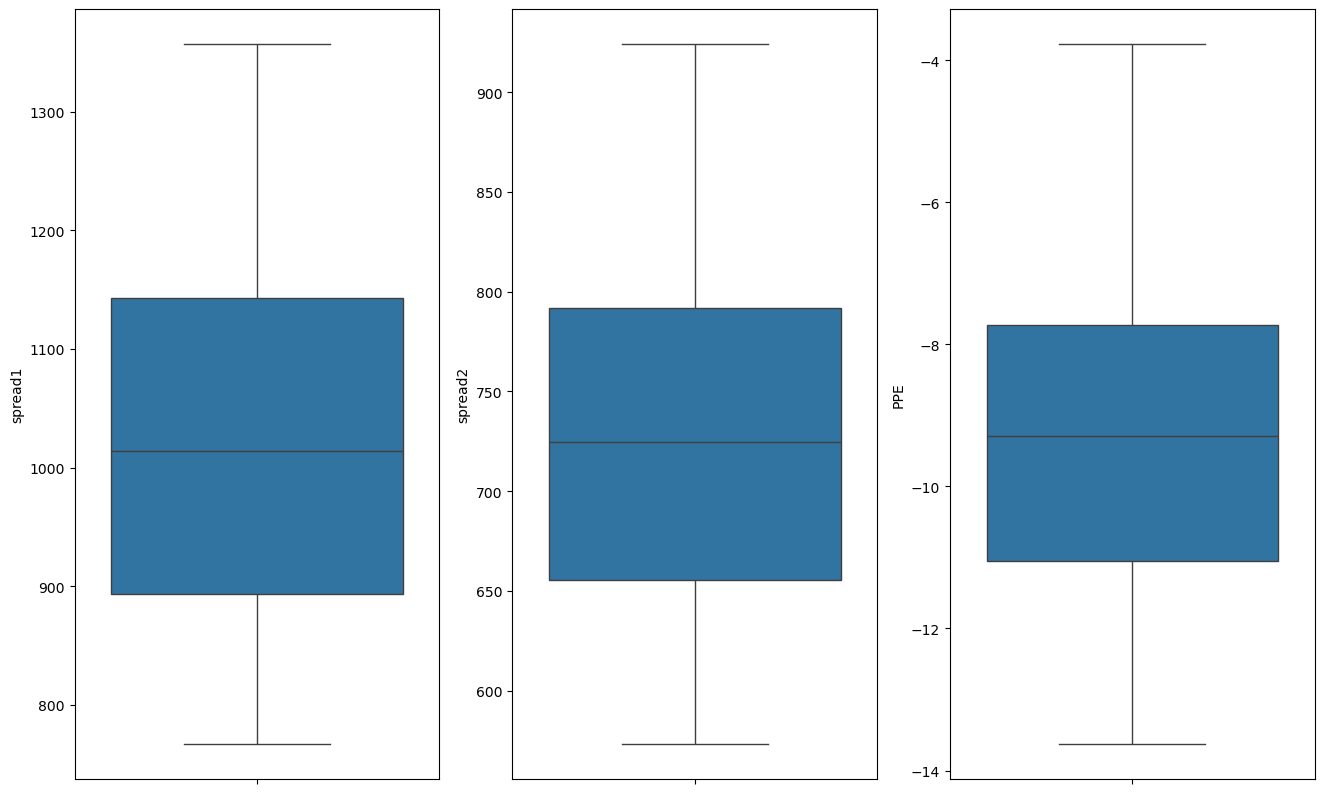

In [41]:
fig, ax = plt.subplots(1,3,figsize=(16,10)) 
sns.boxplot(y='spread1',data=df, ax=ax[0],orient='v') 
sns.boxplot(y='spread2',data=df, ax=ax[1],orient='v')
sns.boxplot(y='PPE',data=df,ax=ax[2],orient='v')

<Axes: xlabel='Shimmer:DDA', ylabel='Density'>

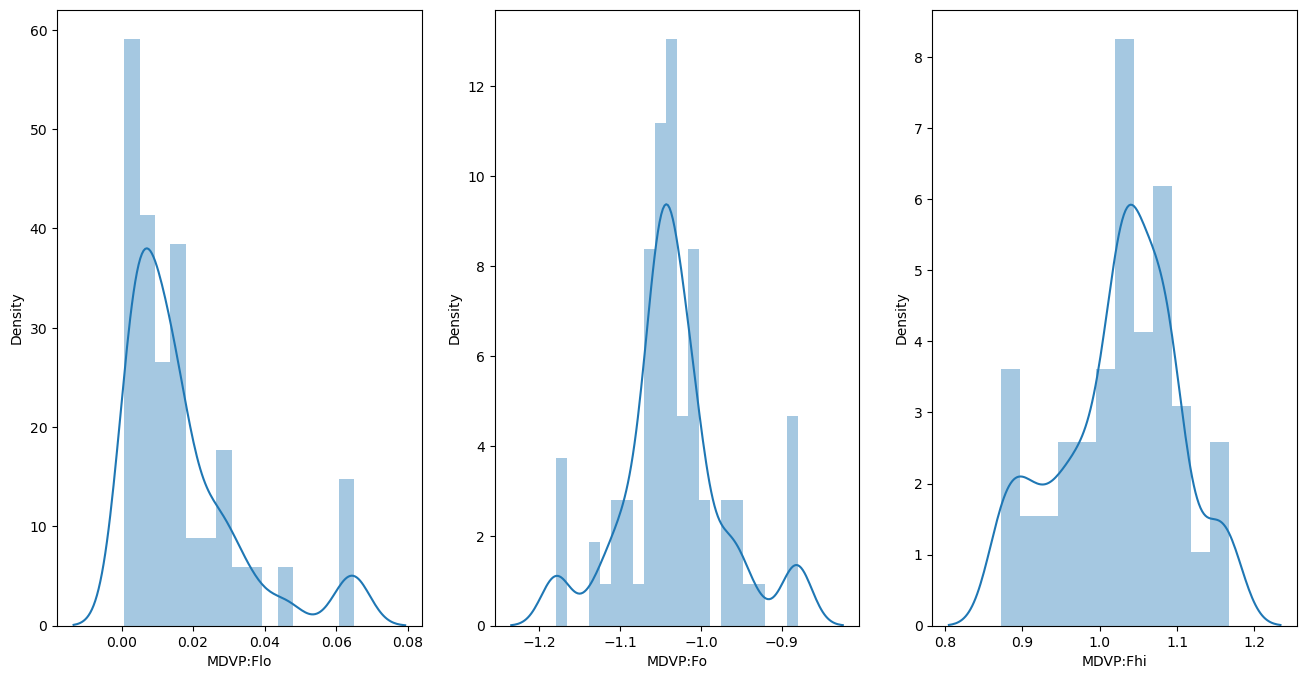

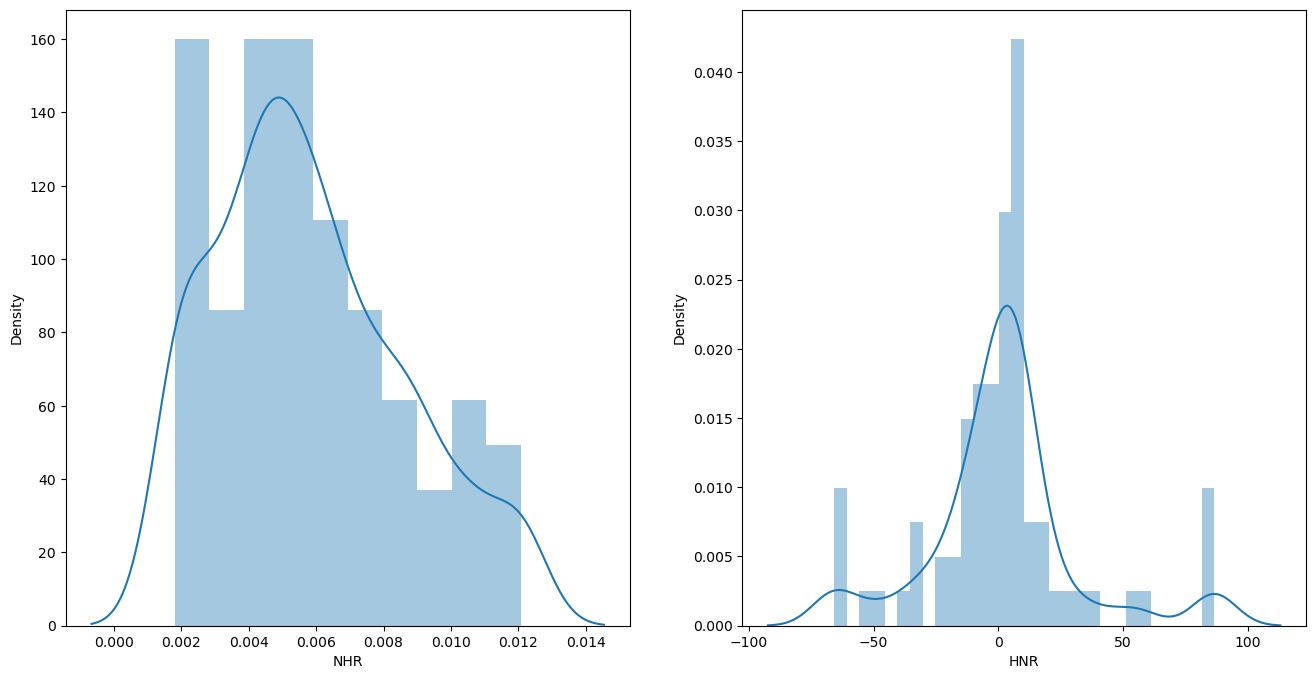

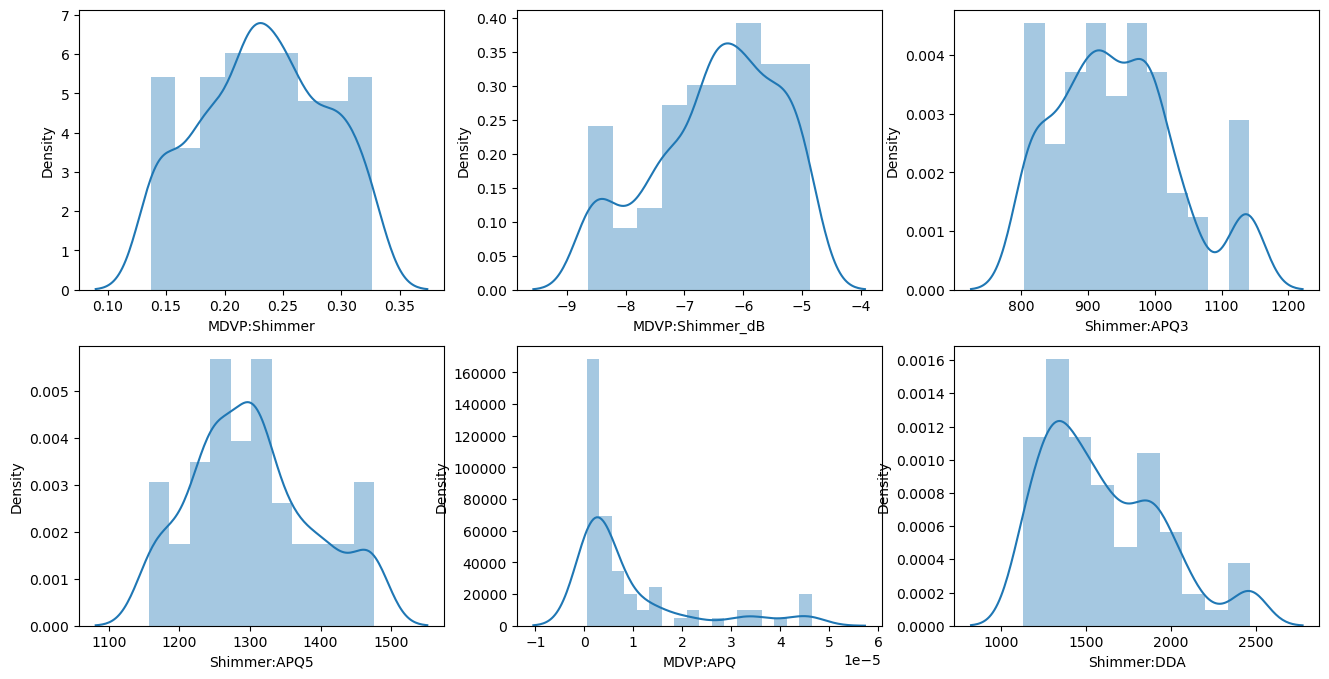

In [42]:
warnings.filterwarnings("ignore", category=UserWarning)
fig, ax = plt.subplots(1,3,figsize=(16,8)) 
sns.distplot(df['MDVP:Flo'],ax=ax[0]) 
sns.distplot(df['MDVP:Fo'],ax=ax[1]) 
sns.distplot(df['MDVP:Fhi'],ax=ax[2])

fig, ax = plt.subplots(1,2,figsize=(16,8)) 
sns.distplot(df['NHR'],ax=ax[0]) 
sns.distplot(df['HNR'],ax=ax[1])

fig, ax = plt.subplots(2,3,figsize=(16,8)) 
sns.distplot(df['MDVP:Shimmer'],ax=ax[0,0]) 
sns.distplot(df['MDVP:Shimmer_dB'],ax=ax[0,1]) 
sns.distplot(df['Shimmer:APQ3'],ax=ax[0,2]) 
sns.distplot(df['Shimmer:APQ5'],ax=ax[1,0]) 
sns.distplot(df['MDVP:APQ'],ax=ax[1,1]) 
sns.distplot(df['Shimmer:DDA'],ax=ax[1,2])

### Bi-Variate Analysis

<Axes: xlabel='spread1', ylabel='Density'>

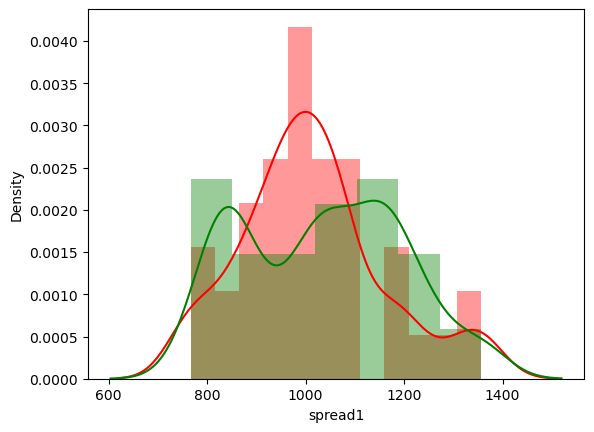

In [43]:
warnings.filterwarnings("ignore", category=UserWarning)
sns.distplot( df[df.Label == 0]['spread1'], color = 'r')
sns.distplot( df[df.Label == 1]['spread1'], color = 'g')

Spread1 is normally distributed between person who have PD and who is normal. People who have spread1 between - 8.5 and -7.5 are more and they are normal. People whose spread1 is between -6.5 and -5 are having PD


<Axes: xlabel='Label', ylabel='MDVP:Fo'>

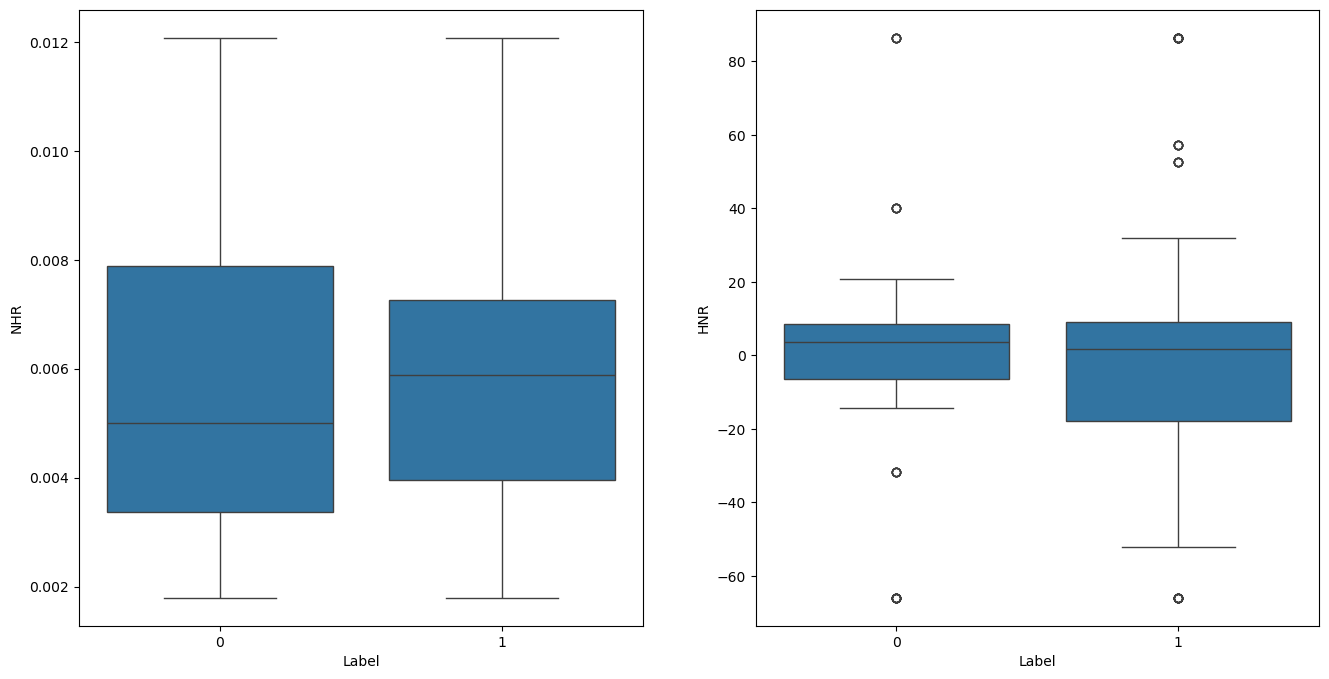

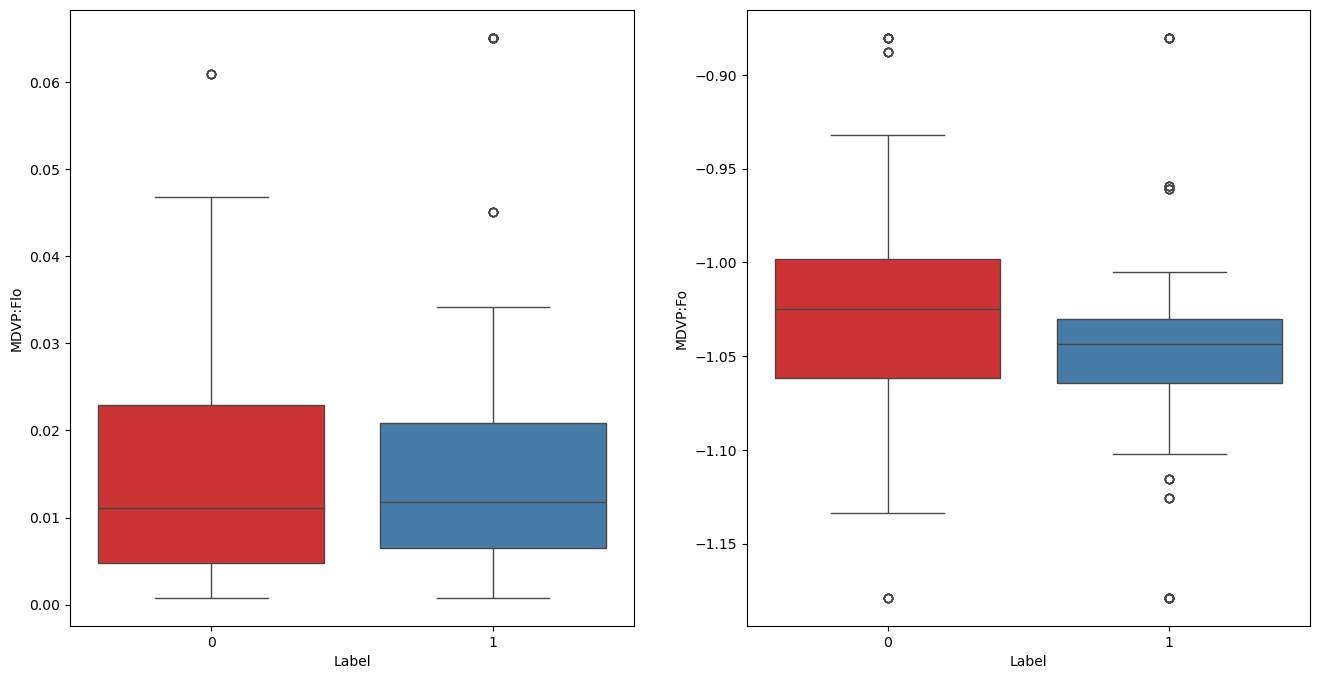

In [44]:
warnings.filterwarnings("ignore", category=FutureWarning)
fig, ax = plt.subplots(1,2,figsize=(16,8))
sns.boxplot(x='Label',y='NHR',data=df,ax=ax[0])
sns.boxplot(x='Label',y='HNR',data=df,ax=ax[1])

fig, ax = plt.subplots(1,2,figsize=(16,8))
sns.boxplot(x='Label',y='MDVP:Flo',data=df,palette="Set1",ax=ax[0])
sns.boxplot(x='Label',y='MDVP:Fo',data=df,palette="Set1",ax=ax[1])

Boxplot 1 : People who have PD(status equal to one) have higher levels of Noise to Harmonic ratio. Also, looking into the HNR ratio people who have PD have lower levels in the same.


Boxplot 2 : When we look the relationship between status and MDVP:Fo(Hz) we can see the median value is around 199 Hz for people who are normal. For people who are affected with Parkinsons the median value comes around 145 Hz

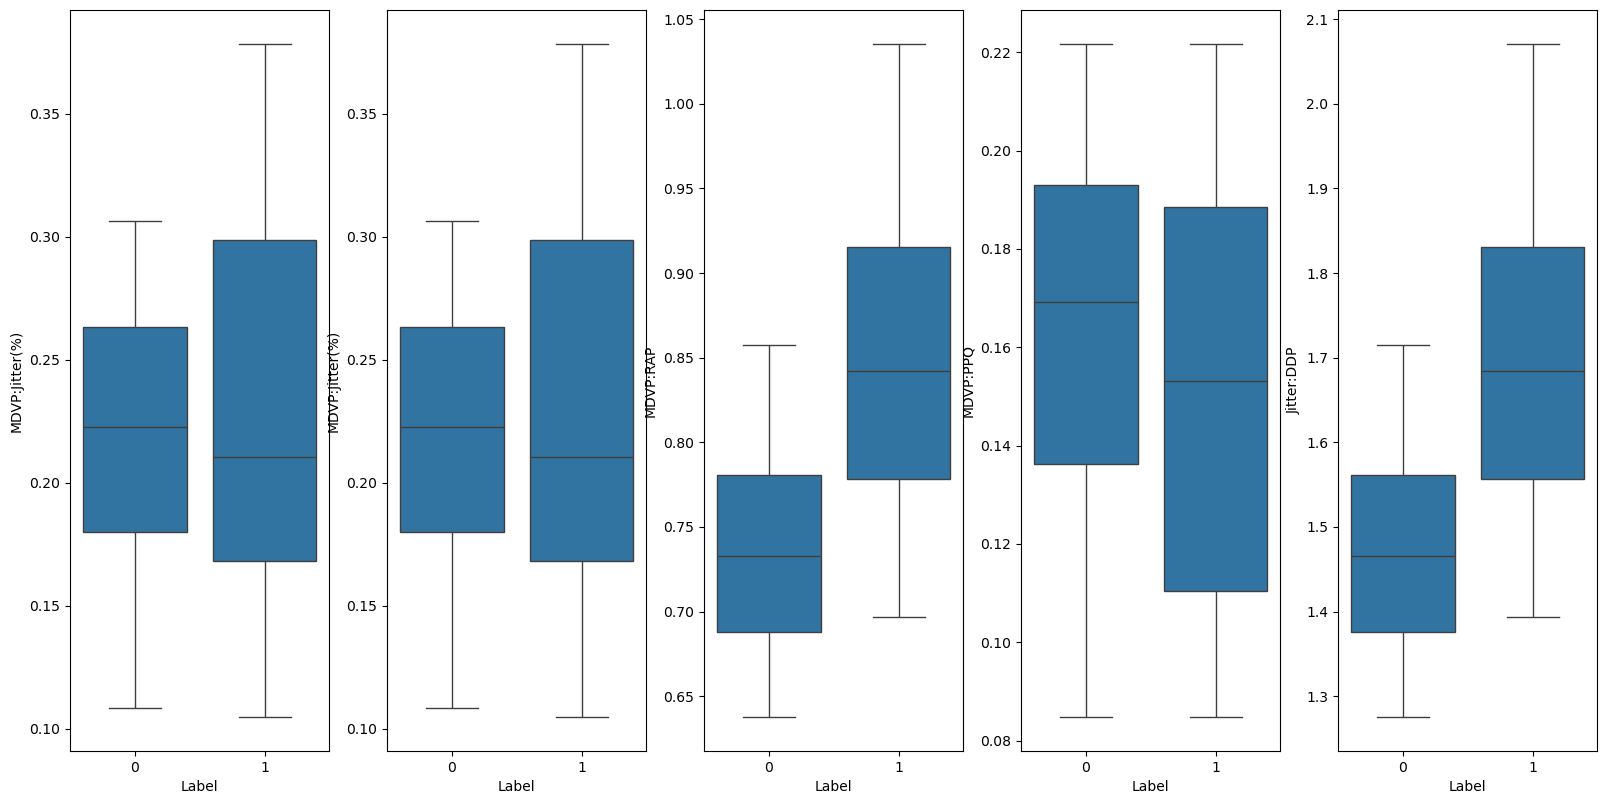

In [45]:
# For categorical predictors
cols = ["MDVP:Jitter(%)","MDVP:Jitter(%)","MDVP:RAP","MDVP:PPQ","Jitter:DDP"]
fig, axs = plt.subplots(ncols = 5,figsize=(16,8))
fig.tight_layout()
for i in range(0,len(cols)):
    sns.boxplot(x='Label',y=cols[i],data=df, ax = axs[i])

People who are suffering for PD tend to have higher jitter %. It seems if the values goes above 0.15 we can confirm the patient is having PD. The variation of fundamental frequency is in a low range for people who is normal.

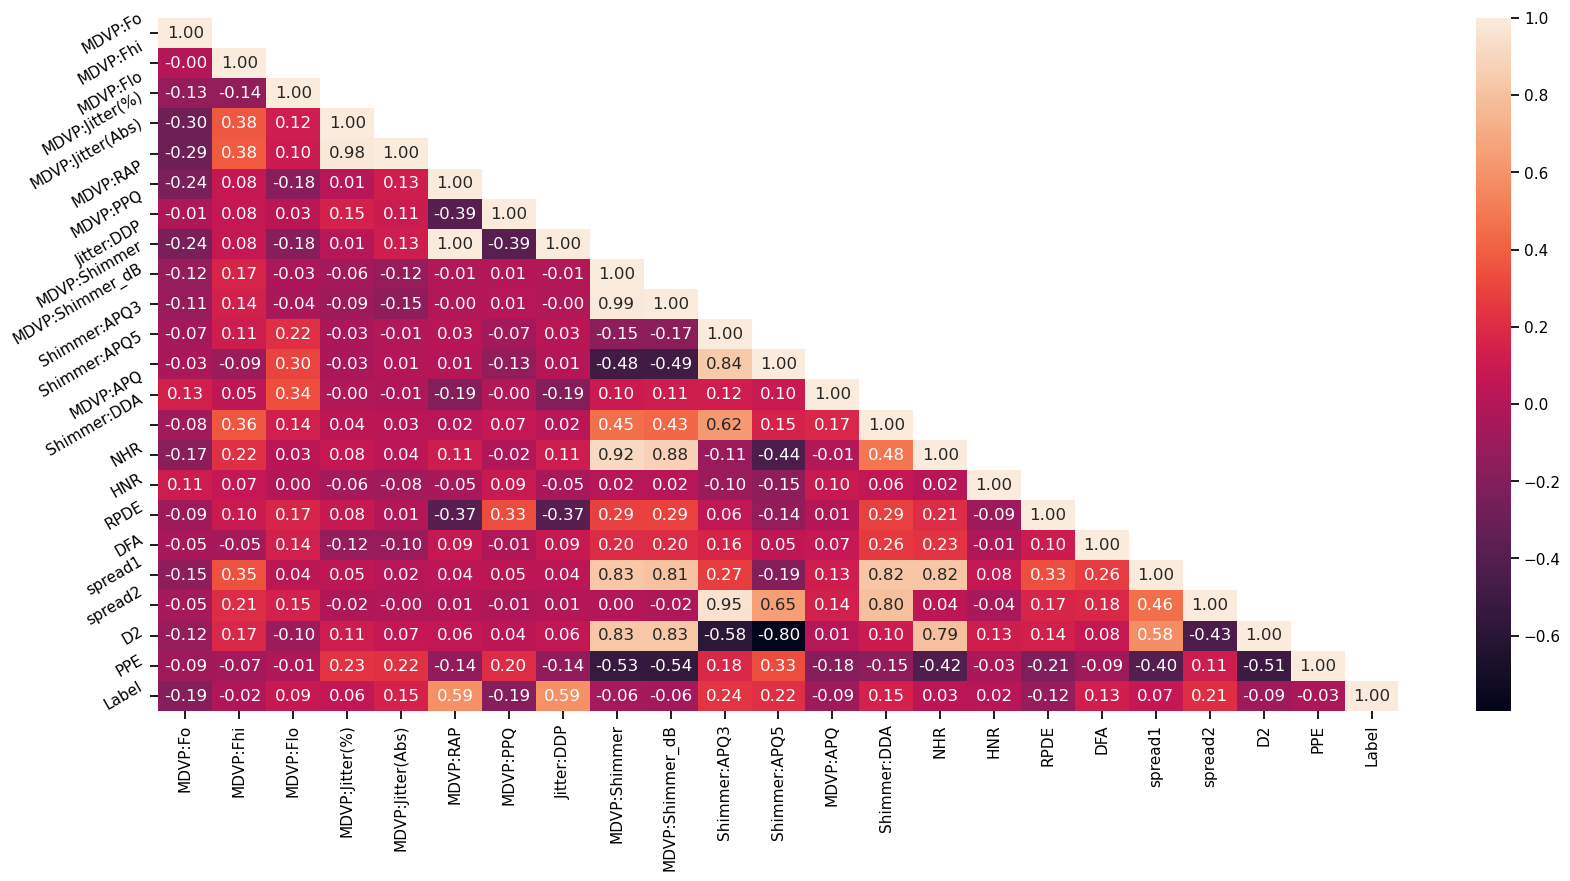

In [46]:
corr = df.corr()
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 3.5})
plt.figure(figsize=(20,9))
# create a mask so we only see the correlation values once
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, 1)] = True
a = sns.heatmap(corr,mask=mask, annot=True, fmt='.2f')
rotx = a.set_xticklabels(a.get_xticklabels(), rotation=90)
roty = a.set_yticklabels(a.get_yticklabels(), rotation=30)

1) MDVP:Jitter(%) has a very high correlation with MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP
2) MDVP:Shimmer has a very correlation with MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA this may be because they are related to each other. This may be because multi-dimensinal voice programs analysis is closely related with these variables
3) The target variable status has a weak positive corelation with spread1

### <font color="blue">Model Building 

In [47]:
print(df.describe().transpose())

X = df.drop("Label",axis=1)
Y = df["Label"]

# Splitting Data into 70% Training data and 30% Testing Data:
X_train, X_test, y_train,  y_test = train_test_split(X, Y,train_size=0.7, test_size=0.3, random_state=42)
print(f'Xtrain Length: {len(X_train)}'),print(f'Xtrain Length: {len(X_test)}')

                  count         mean         std           min          25%  \
MDVP:Fo           474.0    -1.034717    0.063612 -1.178922e+00    -1.063051   
MDVP:Fhi          474.0     1.024805    0.076733  8.719660e-01     0.976579   
MDVP:Flo          474.0     0.016764    0.016245  7.971875e-04     0.005081   
MDVP:Jitter(%)    474.0     0.222136    0.073016  1.048286e-01     0.170547   
MDVP:Jitter(Abs)  474.0     0.171506    0.062649  7.923946e-02     0.133373   
MDVP:RAP          474.0     0.794237    0.100037  6.376601e-01     0.719812   
MDVP:PPQ          474.0     0.158937    0.041314  8.479382e-02     0.123892   
Jitter:DDP        474.0     1.588474    0.200074  1.275320e+00     1.439625   
MDVP:Shimmer      474.0     0.232592    0.053893  1.369391e-01     0.187901   
MDVP:Shimmer_dB   474.0    -6.458809    1.063727 -8.634726e+00    -7.260702   
Shimmer:APQ3      474.0   943.190601   90.988872  8.047555e+02   874.418692   
Shimmer:APQ5      474.0  1303.192412   86.098468  1.

(None, None)

### <font color="red">Decision Tree Model</font>

#### Prepruning

In [48]:

parameters = {
    'criterion': ['gini', 'entropy'],  # Remove 'log_loss' as it's not valid for DecisionTreeClassifier
    'splitter': ['best', 'random'],
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize the DecisionTreeClassifier
treemodel = DecisionTreeClassifier()

# Initialize GridSearchCV with the specified parameters
cv = GridSearchCV(treemodel, param_grid=parameters, cv=5, scoring='accuracy')

# Fit GridSearchCV to find the best parameters
cv.fit(X_train, y_train)

# Get the best parameters found by GridSearchCV
best_params = cv.best_params_
print("Best parameters:", best_params)

# Use the best parameters to create and train the DecisionTreeClassifier
dt_model = DecisionTreeClassifier(**best_params, random_state=100, min_samples_leaf=5)
dt_base_estimator = DecisionTreeClassifier(**best_params)
dt_model.fit(X_train, y_train)

# Evaluate the trained model on the test set
accuracy = dt_model.score(X_test, y_test)
print("Accuracy:", accuracy)

# Make predictions on the test set
y_pred = dt_model.predict(X_test)


Best parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'splitter': 'best'}
Accuracy: 0.8531468531468531


#### Postpruning

In [49]:
## Postpruning
dt_model = DecisionTreeClassifier(criterion='entropy',max_depth=5,random_state=100,min_samples_leaf=5)
dt_model.fit(X_train, y_train)
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=100, splitter='best')

print(dt_model.score(X_test , y_test))
y_pred = dt_model.predict(X_test)

0.8811188811188811


Misclassified samples: 17


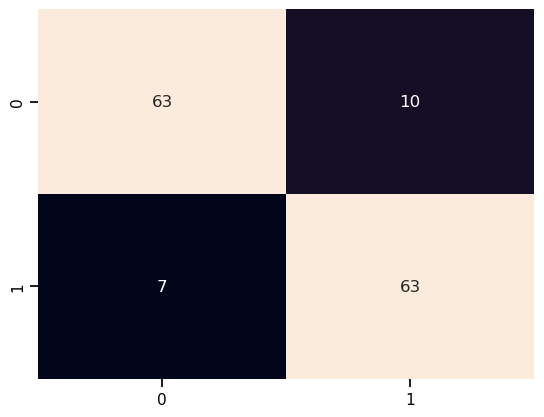

In [50]:
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, cbar=False);

count_misclassified = (y_test != y_pred).sum()
print('Misclassified samples: {}'.format(count_misclassified))

#### Important Features

In [51]:
train_char_label = ['No', 'Yes']
pd_tree_regularized = open('pd_tree_regularized.dot','w')
dot_data = tree.export_graphviz(dt_model, out_file= pd_tree_regularized , feature_names = list(X_train), class_names = list(train_char_label))

pd_tree_regularized.close()

print (pd.DataFrame(dt_model.feature_importances_, columns = ["Imp"], index = X_train.columns))

                       Imp
MDVP:Fo           0.000000
MDVP:Fhi          0.123954
MDVP:Flo          0.000000
MDVP:Jitter(%)    0.000000
MDVP:Jitter(Abs)  0.170719
MDVP:RAP          0.335485
MDVP:PPQ          0.093730
Jitter:DDP        0.093174
MDVP:Shimmer      0.000000
MDVP:Shimmer_dB   0.000000
Shimmer:APQ3      0.091686
Shimmer:APQ5      0.000000
MDVP:APQ          0.000000
Shimmer:DDA       0.000000
NHR               0.000000
HNR               0.000000
RPDE              0.091252
DFA               0.000000
spread1           0.000000
spread2           0.000000
D2                0.000000
PPE               0.000000


#### Decision Tree Visualization

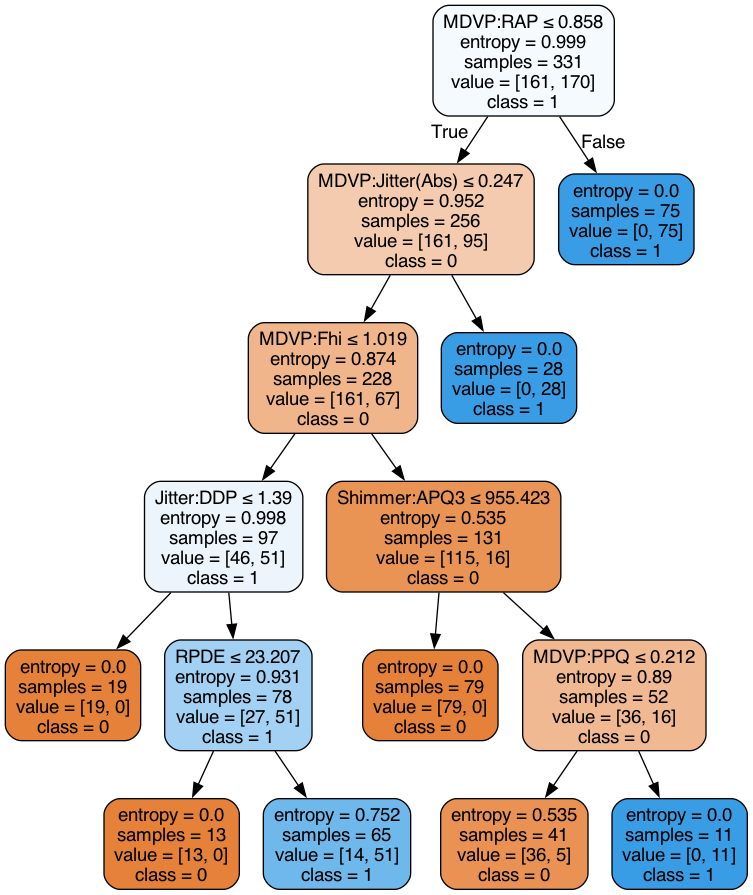

In [52]:
feature_names = df.columns[:-1].tolist()
target_names = [str(label) for label in df['Label'].unique().tolist()]

dot_data = export_graphviz(dt_model, out_file=None, 
                     feature_names=feature_names,  
                     class_names=target_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  

# Render the DOT file to a PNG image
graph = graphviz.Source(dot_data)
graph.render("Parkinsons_decision_tree", format="png")
Image("/Users/yashtembhurnikar/Programming/Pccoe Final Year/Parkinson's Detection/Parkinsons_decision_tree.png")

#### <font color="green">Save Decision Tree Model in joblib</font>

In [53]:
joblib.dump(dt_model, "/Users/yashtembhurnikar/Programming/Pccoe Final Year/Parkinson's Detection/Models/Audio_decision_tree_model.joblib")

["/Users/yashtembhurnikar/Programming/Pccoe Final Year/Parkinson's Detection/Models/Audio_decision_tree_model.joblib"]

### <font color="red">Random Forest Model</font>

In [54]:
rf_model = RandomForestClassifier()
# Example parameter grid for Random Forest
rf_parameters = {
    'n_estimators': [50, 100, 150, 200, 250, 300],  # Number of trees in the forest
    'criterion': ['gini', 'entropy'],  # Splitting criterion
    'max_depth': [None, 10, 20],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required at each leaf node
}

# Perform grid search
rf_cv = GridSearchCV(rf_model, param_grid=rf_parameters, cv=5, scoring='accuracy')
rf_cv.fit(X_train, y_train)
print("Best parameters:", rf_cv.best_params_)

rf_model = RandomForestClassifier(**rf_cv.best_params_)
rf_model.fit(X_train, y_train)

print("Accuracy on test set:", rf_model.score(X_test, y_test))
y_pred = rf_model.predict(X_test)

count_misclassified = (y_test != y_pred).sum()
print('Misclassified samples in Random Forest: {}'.format(count_misclassified))

Best parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy on test set: 1.0
Misclassified samples in Random Forest: 0


#### Important Features for Random Forest model

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


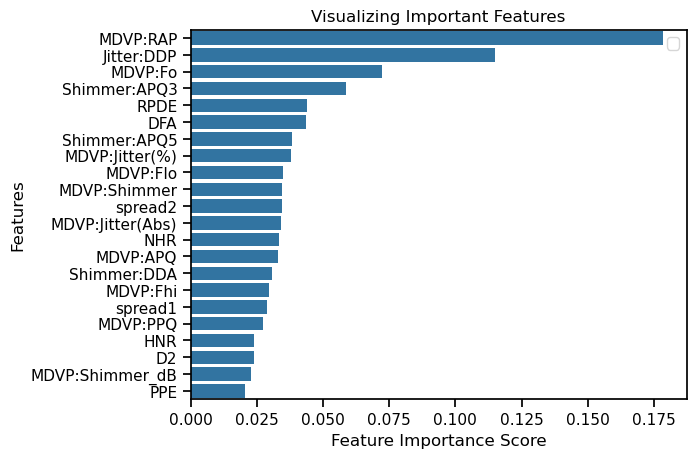

In [55]:
feature_imp = pd.Series(rf_model.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

#### <font color="green">Save Random Forest Model in joblib</font>

In [56]:
joblib.dump(rf_model, "/Users/yashtembhurnikar/Programming/Pccoe Final Year/Parkinson's Detection/Models/Audio_random_forest_model.joblib")

["/Users/yashtembhurnikar/Programming/Pccoe Final Year/Parkinson's Detection/Models/Audio_random_forest_model.joblib"]

### <font color="red">Bagging Model</font>

In [57]:
# Instantiate the Bagging Classifier with Random Forest: Create an instance of the BaggingClassifier with the RandomForestClassifier as the base estimator.
bagging_model = BaggingClassifier(base_estimator=RandomForestClassifier(**rf_cv.best_params_), n_estimators=10, random_state=100)
bagging_model.fit(X_train, y_train)
print("Accuracy on test set:", bagging_model.score(X_test, y_test))
y_pred = bagging_model.predict(X_test)

count_misclassified = (y_test != y_pred).sum()
print('Misclassified samples in Bagging: {}'.format(count_misclassified))

Accuracy on test set: 1.0
Misclassified samples in Bagging: 0


#### <font color="green">Saving Bagging Model in joblib</font>

In [58]:
joblib.dump(bagging_model, "/Users/yashtembhurnikar/Programming/Pccoe Final Year/Parkinson's Detection/Models/Audio_bagging_model.joblib")

["/Users/yashtembhurnikar/Programming/Pccoe Final Year/Parkinson's Detection/Models/Audio_bagging_model.joblib"]

### AdaBoost Model
AdaBoost is typically used with weak learners, such as shallow decision trees or even stumps (trees with only one split)

#### Note:
AdaBoost with Random Forest might not provide significant improvements in performance and could potentially lead to overfitting or increased computational complexity without much benefit

### <font color="red">Using the AdaBoost model on Decision Tree</font>
Create an instance of the AdaBoostClassifier with DecisionTreeClassifier as the base estimator.

In [59]:
ada_boost_model = AdaBoostClassifier(base_estimator=dt_model, n_estimators=50, random_state=100)
ada_boost_model.fit(X_train, y_train)
print("Accuracy on test set:", ada_boost_model.score(X_test, y_test))
y_pred = ada_boost_model.predict(X_test)

Accuracy on test set: 1.0


### <font color="green">Save the Adaboost Model

In [60]:
joblib.dump(ada_boost_model, "/Users/yashtembhurnikar/Programming/Pccoe Final Year/Parkinson's Detection/Models/Audio_adaboost_model.joblib")

["/Users/yashtembhurnikar/Programming/Pccoe Final Year/Parkinson's Detection/Models/Audio_adaboost_model.joblib"]

### <font color="red">Gradient Boosting Model</font>

In the Gradient Boosting framework, the base estimator refers to the weak learner used at each stage of boosting. By default, the base estimator in scikit-learn's GradientBoostingClassifier is a decision tree. However, unlike AdaBoost, Gradient Boosting does not have a separate parameter to specify the base estimator. Instead, it builds an ensemble of decision trees internally.

In [61]:
gradient_boost_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=100)
gradient_boost_model.fit(X_train, y_train)
print("Accuracy on test set:", gradient_boost_model.score(X_test, y_test))
y_pred = gradient_boost_model.predict(X_test)

Accuracy on test set: 1.0


#### <font color="green">Saving Gradient Boosting Model

In [62]:
joblib.dump(gradient_boost_model, "/Users/yashtembhurnikar/Programming/Pccoe Final Year/Parkinson's Detection/Models/Audio_gradient_boosting_model.joblib")

["/Users/yashtembhurnikar/Programming/Pccoe Final Year/Parkinson's Detection/Models/Audio_gradient_boosting_model.joblib"]

### <font color="red">XGBoosting Model</font>

In [63]:
xgb_model = XGBClassifier(base_estimator=dt_model,n_estimators=100, learning_rate=0.1, random_state=100)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 1.0


#### <font color="green">Saving XGBoosting Model

In [64]:
joblib.dump(xgb_model, "/Users/yashtembhurnikar/Programming/Pccoe Final Year/Parkinson's Detection/Models/Audio_xgboost_model.joblib")

["/Users/yashtembhurnikar/Programming/Pccoe Final Year/Parkinson's Detection/Models/Audio_xgboost_model.joblib"]

### <font color="red">Support Vector Machine Model</font>

In [78]:
# Generate synthetic dataset
X, y = make_classification(n_samples=1000, n_features=22, n_classes=2, random_state=42)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Initialize SVM classifier
svm = SVC()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV to find the best parameters
grid_search.fit(X_train, y_train)

# Get the best parameters found by GridSearchCV
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Use the best parameters to create and train the SVM classifier
best_svm = SVC(**best_params)
best_svm.fit(X_train, y_train)

# Evaluate the trained model on the test set
predictions = best_svm.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
recall = recall_score(y_test, predictions)

print(f"The accuracy is {accuracy * 100:.2f} %")
print(f"The f1 score is {f1 * 100:.2f} %") 
print(f"The recall is {recall * 100:.2f} %")


Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
The accuracy is 86.00 %
The f1 score is 85.86 %
The recall is 81.73 %


#### <font color="green">Saving SVM Model

In [79]:
joblib.dump(best_svm, "/Users/yashtembhurnikar/Programming/Pccoe Final Year/Parkinson's Detection/Models/Audio_svm_model.joblib")

["/Users/yashtembhurnikar/Programming/Pccoe Final Year/Parkinson's Detection/Models/Audio_svm_model.joblib"]

### <font color="red">KNN Model

In [89]:
# Generate synthetic dataset
X, y = make_classification(n_samples=1000, n_features=22, n_classes=2, random_state=42)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Initialize KNN classifier
knn = KNeighborsClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV to find the best parameters
grid_search.fit(X_train, y_train)

# Get the best parameters found by GridSearchCV
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Use the best parameters to create and train the KNN classifier
best_knn = KNeighborsClassifier(**best_params)
best_knn.fit(X_train, y_train)

# Evaluate the trained model on the test set
accuracy = best_knn.score(X_test, y_test)
print("Accuracy:", accuracy*100)


Best parameters: {'algorithm': 'auto', 'n_neighbors': 13, 'weights': 'uniform'}
Accuracy: 84.0


#### <font color="green">Saving KNN Model

In [86]:
joblib.dump(best_knn, "/Users/yashtembhurnikar/Programming/Pccoe Final Year/Parkinson's Detection/Models/Audio_knn_model.joblib")

["/Users/yashtembhurnikar/Programming/Pccoe Final Year/Parkinson's Detection/Models/Audio_knn_model.joblib"]

### <font color="red">Naive Bayes Model

Best Parameters for Naive Bayes: {'var_smoothing': 1e-09}
Naive Bayes Accuracy: 84.00%
Naive Bayes F1 Score: 83.84%
Naive Bayes Recall: 79.81%


<Axes: >

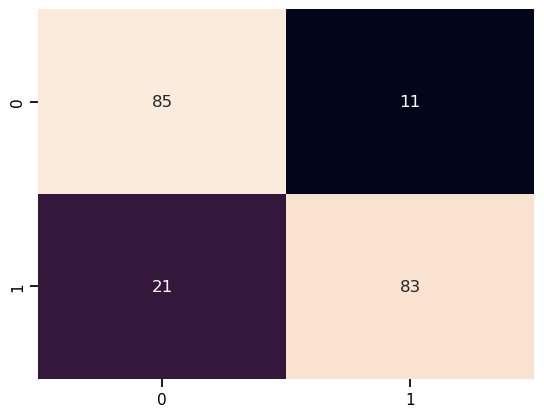

In [88]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB

# Define the model
model_nb = GaussianNB()

# Define the parameters grid to search
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=model_nb, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best model and its parameters
best_model_nb = grid_search.best_estimator_
best_params_nb = grid_search.best_params_

# Fit the best model to the data
best_model_nb.fit(X_train, y_train)

# Make predictions with the best model
predictions_nb = best_model_nb.predict(X_test)

# Evaluate the best model
accuracy = accuracy_score(y_test, predictions_nb) * 100
f1 = f1_score(y_test, predictions_nb) * 100
recall = recall_score(y_test, predictions_nb) * 100

print("Best Parameters for Naive Bayes:", best_params_nb)
print(f"Naive Bayes Accuracy: {accuracy:.2f}%")
print(f"Naive Bayes F1 Score: {f1:.2f}%")
print(f"Naive Bayes Recall: {recall:.2f}%")
sns.heatmap(confusion_matrix(y_test, predictions_nb), annot=True, cbar=False)


#### <font color="green">Saving Naive Bayes Model

In [85]:
joblib.dump(model_nb, "/Users/yashtembhurnikar/Programming/Pccoe Final Year/Parkinson's Detection/Models/Audio_naive_bayes_model.joblib")

["/Users/yashtembhurnikar/Programming/Pccoe Final Year/Parkinson's Detection/Models/Audio_naive_bayes_model.joblib"]

### <font color="red">Voting Classifier

In [90]:
from sklearn.ensemble import VotingClassifier


voting_clf = VotingClassifier(estimators=[
    ('decision_tree', dt_model),
    ('random_forest', rf_model),
    ('xgboost', xgb_model),
    ('svm', best_svm),
    ('knn', best_knn),
    ('naive_bayes', model_nb),
    ('bagging', bagging_model),
    ('adaboost', ada_boost_model),
    ('gradient_boosting', gradient_boost_model)
], voting='hard')

voting_clf.fit(X_train, y_train)
accuracy = voting_clf.score(X_test, y_test)
print("Accuracy:", accuracy*100)

Accuracy: 90.5


#### <font color="green">Saving Voting Model

In [91]:
joblib.dump(voting_clf, "/Users/yashtembhurnikar/Programming/Pccoe Final Year/Parkinson's Detection/Models/Audio_voting_classifier.joblib")

["/Users/yashtembhurnikar/Programming/Pccoe Final Year/Parkinson's Detection/Models/Audio_voting_classifier.joblib"]